# Benchmark GMM Dorso

### Outline
* generate expression matrix - ground truth (atlas, see normal droso tutorial)
* generate expression matrix - normal reconstruction (see normal droso tutorial)
* generate expression matrix - GMM (see "cleaning demonstration) - maybe different modes

* calculate similarity values of the matrixes
* plot them

Infos:

"dge_rep" mode: None (there are different possibilities, maybe try other later)


In [20]:
# install
# pip install novosparc
# imports
from importlib import reload

import anndata
%matplotlib inline
import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import zscore

import random
random.seed(42)

# working directory
# os.chdir("/home/vfs/PycharmProjects/rajewskyLab/novosparc") # when I use this the notebook does not use the normal novosparc anymore - but when I put the notebooke physically in that directory everything works normally - where does this come from?

# test genes
pl_genes = ['sna', 'ken', 'eve','zen2','ImpE2']

# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)
# optional: subset cells
num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)
# dge_rep mode
dge_rep = None # a representation of cells gene expression
# highly var genes
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# atlas settings
atlas_dir = 'novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039 # coming from the spatial data
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

number of cells: 1297
number of genes: 8924


In [21]:
## Expression Matrix - ground truth
locations = locations_apriori
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

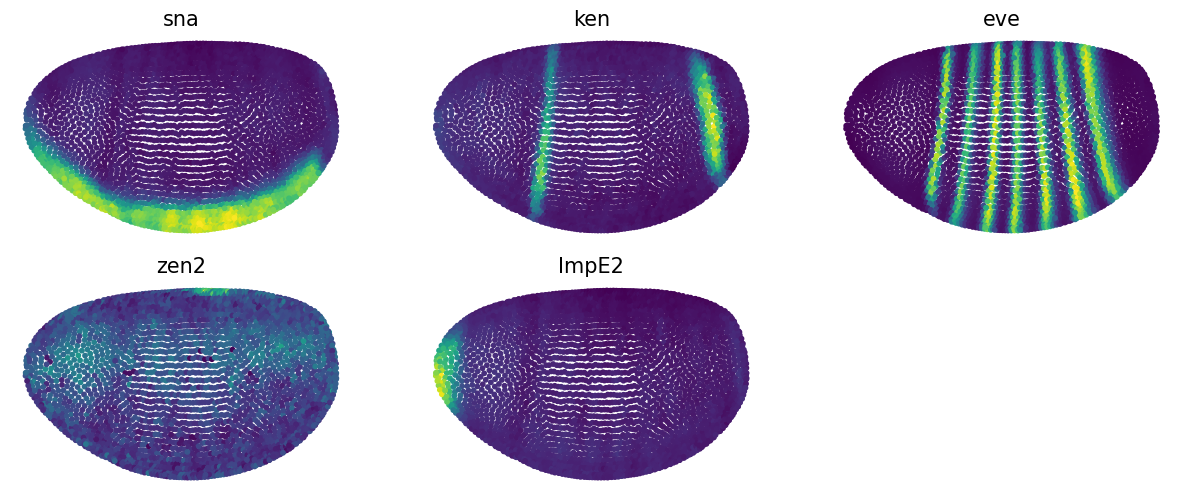

<Figure size 432x288 with 0 Axes>

In [22]:
# test
novosparc.pl.embedding(atlas, pl_genes)

In [23]:
expmtrx_truth = atlas.X

# # min-max normalization
# expmtrx_truth_normed = (expmtrx_truth - np.min(expmtrx_truth))/ (np.max(expmtrx_truth) - np.min(expmtrx_truth))

In [24]:
# zscore
expmtrx_truth_normed = zscore(expmtrx_truth)
expmtrx_truth_normed.shape

(3039, 84)

 ## Expression Matrix - basic reconstruction

In [25]:
# calculate cost matrix
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# dge_rep = None
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations_apriori

Setting up for reconstruction ... done ( 4.06 seconds )
Setting up for reconstruction ... done ( 3.86 seconds )
Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


<ipython-input-25-898605d05a00>:31: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [26]:
# plt.hist(tissue.gw)

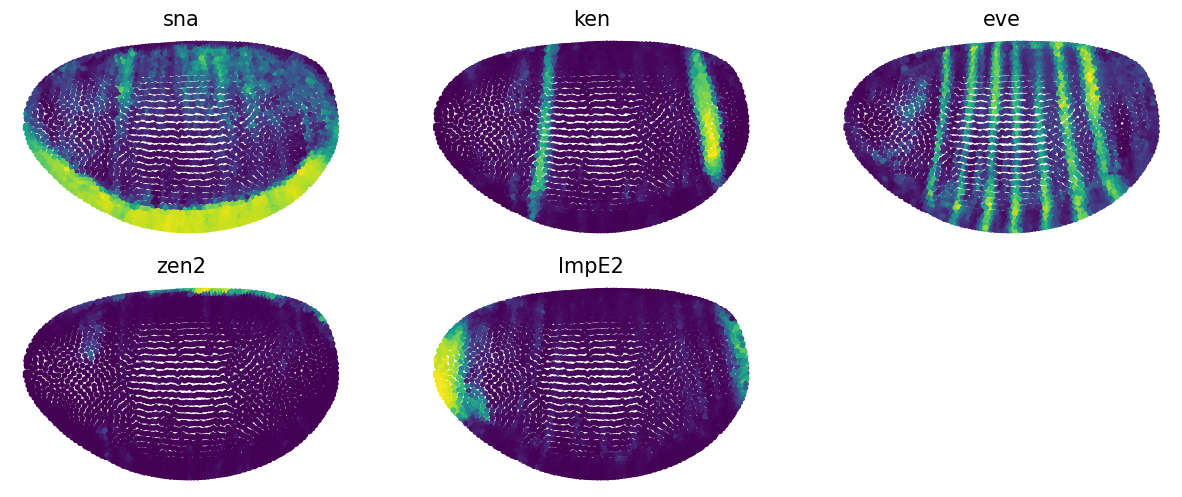

<Figure size 432x288 with 0 Axes>

In [27]:
# test
novosparc.pl.embedding(dataset_reconst, pl_genes)

In [28]:
subset_cols = []
for i, gene in enumerate(atlas_genes):
    if gene in dataset_reconst.var_names:
        subset_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1, 1))
exprmtrx_simplerecon = np.concatenate(subset_cols, axis=1)

In [29]:
# # min-max normalization
# exprmtrx_simplerecon_normed = (exprmtrx_simplerecon - np.min(exprmtrx_simplerecon))/ (np.max(exprmtrx_simplerecon) - np.min(exprmtrx_simplerecon))

In [30]:
# zscore
exprmtrx_simplerecon_normed = zscore(exprmtrx_simplerecon)
exprmtrx_simplerecon_normed.shape

(3039, 84)

In [31]:
type(atlas_genes)

list

## Expression Matrix - basic cleaning

ToDo: I should think about how to do this in a function so I can do this for multiple settings. Outputting a list of expression matrixes, which I then can use for all the calculations and stuff

In [32]:
# construct tissue object
tissue_postcleaned = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

# alternative 1: setup both assumptions
tissue_postcleaned.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

tissue_postcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue_postcleaned.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue_postcleaned.sdge

dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations_apriori
# GMM
tissue_postcleaned.cleaning_expression_data(dataset_reconst_postcleaned,tissue_postcleaned.sdge.T,normalization='zscore', selected_genes=atlas_genes)

# reconstructed expression of individual genes
sdge_postcleaned = tissue_postcleaned.cleaned_dge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations_apriori

Setting up for reconstruction ... done ( 3.93 seconds )
Setting up for reconstruction ... done ( 4.57 seconds )
Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


<ipython-input-32-323b7a128197>:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vschuma/anaconda3/envs/NovoSpaRc/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not conv

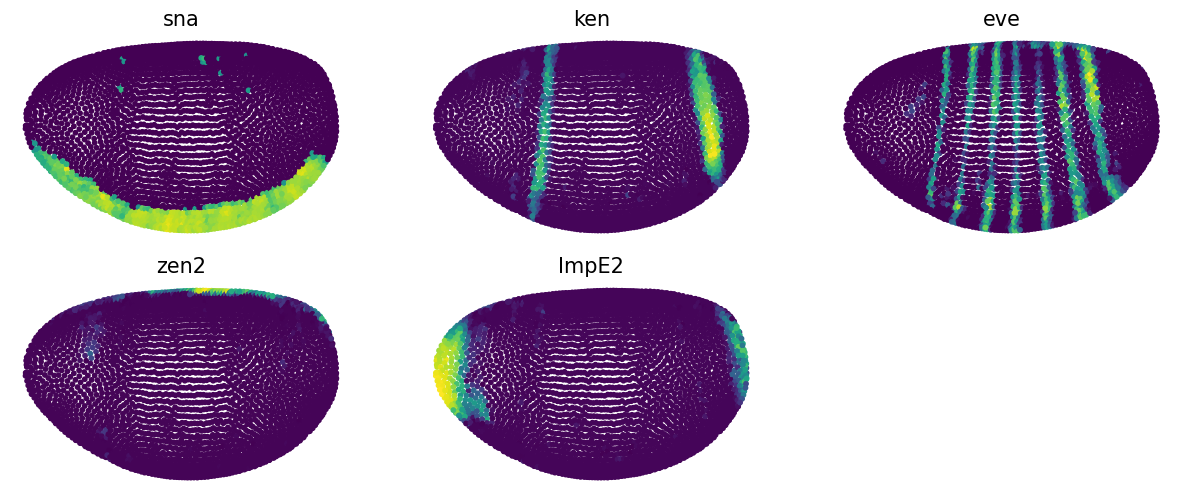

<Figure size 432x288 with 0 Axes>

In [33]:
# test
novosparc.pl.embedding(dataset_reconst_postcleaned, pl_genes)

In [34]:
subset_cols = []
for i, gene in enumerate(atlas_genes):
    if gene in dataset_reconst_postcleaned.var_names:
        subset_cols.append(np.asarray(dataset_reconst_postcleaned[:, gene].X).reshape(-1, 1))
exprmtrx_recon_defaultGMM = np.concatenate(subset_cols, axis=1)

In [35]:
# min-max normalization
# exprmtrx_recon_defaultGMM_normed = (exprmtrx_recon_defaultGMM - np.min(exprmtrx_recon_defaultGMM))/ (np.max(exprmtrx_recon_defaultGMM) - np.min(exprmtrx_recon_defaultGMM))

In [36]:
# zscore norm
# should be already normalized
exprmtrx_recon_defaultGMM_normed = exprmtrx_recon_defaultGMM

In [37]:

exprmtrx_recon_defaultGMM_normed.shape

(3039, 84)

## Comparing results
ToDo: also make this a function you can loop though just plotting the results in the end

In [73]:
def mse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

def rmse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

def mean_pearson(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = pearsonr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def box_swarm_label(plot_df, single_dfs=None):
    ## plot_df must contain columns "gene", "r score (pearson)", and "method" (being the  reconstruction/cleaning)

    figure(figsize=(11, 12), dpi=80)

    sns.boxplot(x="method", y="r score (pearson)", data=plot_df, whis=np.inf)
    sns.swarmplot(x="method", y="r score (pearson)", data=plot_df,
                  palette=["crimson","indigo"])

    if single_dfs:
        for counter, single_df in enumerate(single_dfs):

            for x,y, label in zip([counter]*len(plot_df), single_df["r score (pearson)"], single_df["gene"]):
                plt.text(x = x + 0.1, y = y,
                         s = label,
                         rotation= 45)
    plt.show()

def filter_matrix_for_genes(dataframe, gene_list):
    filtered_df = dataframe[dataframe.gene.isin(gene_list)]
    return filtered_df

In [39]:
print("mse: true-recon", mse(expmtrx_truth_normed,exprmtrx_simplerecon_normed))
print("mse: true-cleaned", mse(expmtrx_truth_normed,exprmtrx_recon_defaultGMM_normed))

print("mean pearson coeff: true-recon", mean_pearson(expmtrx_truth_normed, exprmtrx_simplerecon_normed))
print("mean pearson coeff: true-cleaned", mean_pearson(expmtrx_truth_normed, exprmtrx_recon_defaultGMM_normed))
print("rmse: true-recon", rmse(expmtrx_truth_normed,exprmtrx_simplerecon_normed))
print("rmse: true-cleaned", rmse(expmtrx_truth_normed,exprmtrx_recon_defaultGMM_normed))

mse: true-recon 0.6167897
mse: true-cleaned 0.70167565
mean pearson coeff: true-recon ([0.4600468486341184, 0.7467303143707126, 0.7809280213418741, 0.6936953862959236, 0.7966829955973225, 0.6663032237445425, 0.6487112299425775, 0.6938221587032184, 0.8348277108230615, 0.7166865655460126, 0.5749552044403861, 0.5327617629494318, 0.6010705582822812, 0.6377399073662781, 0.7793203063134764, 0.3993055494376532, 0.5115398182455241, 0.5762996423308868, 0.7285275980196123, 0.6585572137241782, 0.8137630715984756, 0.8223949527868597, 0.7762105188136598, 0.5925508307119494, 0.5797909273833289, 0.747216836566863, 0.7575697932024869, 0.6529194404938937, 0.9109753773590552, 0.7516817533604176, 0.7115544538431711, 0.3353577976514668, 0.8648058072169892, 0.7419307691366198, 0.5721773934263314, 0.39249978339886554, 0.8868289636651745, 0.726075595017166, 0.2453636192176855, 0.8329961810154862, 0.9415401620490815, 0.6498945395301914, 0.6283998351553286, 0.7018523716994554, 0.7830115800466765, 0.76866065612

In [40]:
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_pearson(expmtrx_truth_normed, exprmtrx_simplerecon_normed)
corre_reconstruction = pd.DataFrame(list(zip(atlas_genes,r_values_recon, method_recon)),
                                    columns=["gene","r score (pearson)","method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
r_values_clean, mean_corre_clean = mean_pearson(expmtrx_truth_normed, exprmtrx_recon_defaultGMM_normed)
corre_cleaned = pd.DataFrame(list(zip(atlas_genes,r_values_clean, method_clean)),
                                    columns=["gene","r score (pearson)","method"])

pearson_corre_plt = pd.concat([corre_reconstruction,corre_cleaned])

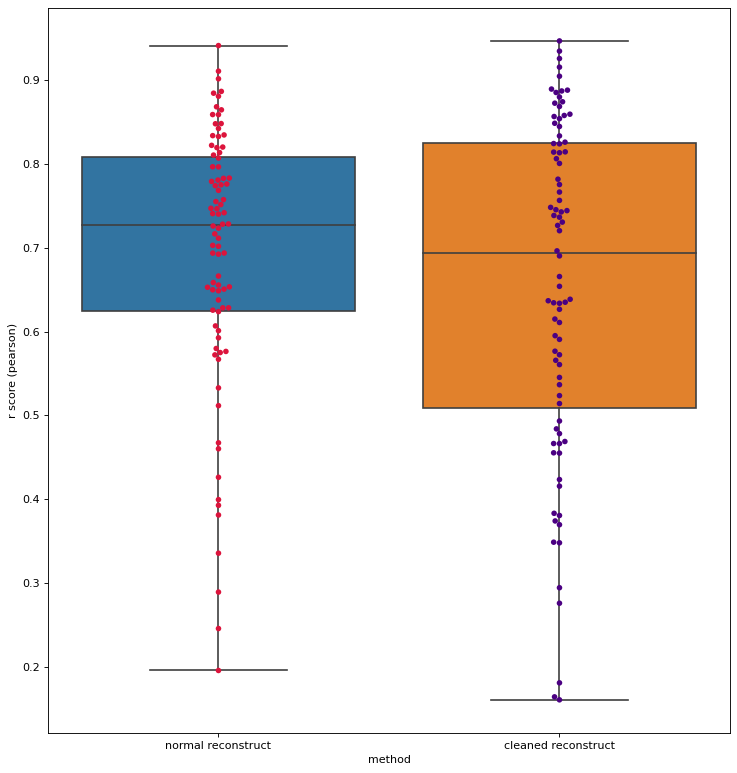

In [74]:
box_swarm_label(pearson_corre_plt)

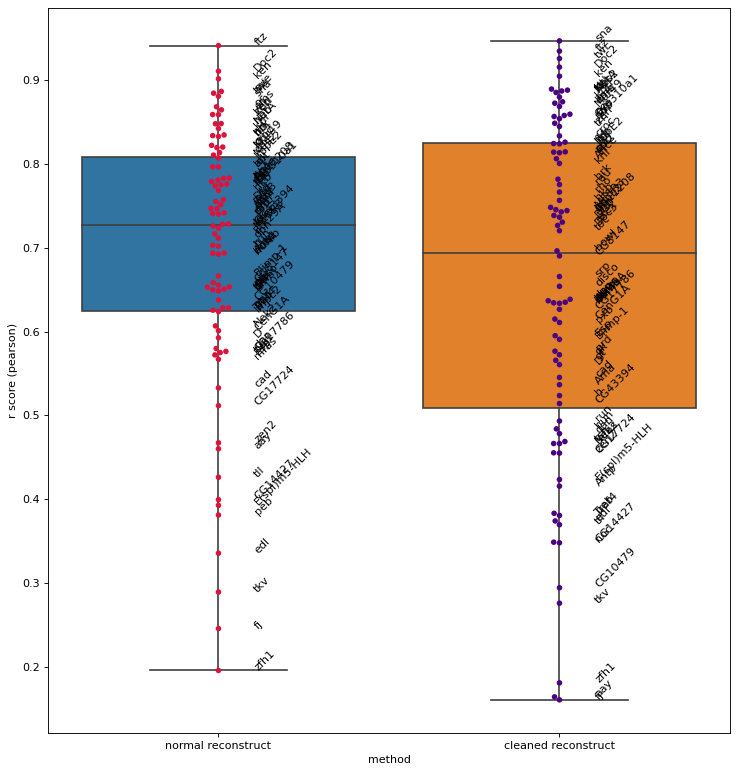

In [59]:
box_swarm_label(pearson_corre_plt,[corre_reconstruction,corre_cleaned])

AttributeError: 'AxesSubplot' object has no attribute 'box_swarm_label'

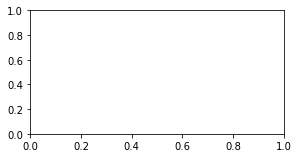

In [69]:
from matplotlib.gridspec import GridSpec
# plotting genes of interest
invest_genes1 = pl_genes = ['sna', 'ken', 'eve','zen2','ImpE2']
# high scoring genes
high_score_genes = list(corre_reconstruction[corre_reconstruction["r score (pearson)"] >=0.8].gene)
# low scoring genes
low_score_genes = list(corre_reconstruction[corre_reconstruction["r score (pearson)"] <=0.5].gene)

# I think this should also be loopable
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(nrows=2, ncols=2)
# pearson_invest_genes1
ax0 = fig.add_subplot(gs[0, 0])
ax0.box_swarm_label(filter_matrix_for_genes(pearson_corre_plt,invest_genes1),
                [filter_matrix_for_genes(corre_reconstruction,invest_genes1),
                filter_matrix_for_genes(corre_cleaned,invest_genes1)])

ax1 = fig.add_subplot(gs[1, 0])
ax1.box_swarm_label(filter_matrix_for_genes(pearson_corre_plt,high_score_genes),
                [filter_matrix_for_genes(corre_reconstruction,high_score_genes),
                filter_matrix_for_genes(corre_cleaned,high_score_genes)])

ax2 = fig.add_subplot(gs[:, 1])
ax2.box_swarm_label(filter_matrix_for_genes(pearson_corre_plt,low_score_genes),
                [filter_matrix_for_genes(corre_reconstruction,low_score_genes),
                filter_matrix_for_genes(corre_cleaned,low_score_genes)])

['brk',
 'cnc',
 'croc',
 'Doc2',
 'ems',
 'eve',
 'fkh',
 'ftz',
 'htl',
 'ImpE2',
 'ken',
 'kni',
 'knrl',
 'Kr',
 'Mdr49',
 'Mes2',
 'NetA',
 'nub',
 'oc',
 'sna',
 'twi',
 'zen']

In [45]:
# zscore norm
# should be already normalized
exprmtrx_recon_defaultGMM_normed = exprmtrx_recon_defaultGMM

0
1
2
3
4


In [45]:

exprmtrx_recon_defaultGMM_normed.shape

## Comparing results
ToDo: also make this a function you can loop though just plotting the results in the end

Mean pearson coeff is: 0.6916052342560141


84

In [58]:
def mse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

def rmse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

def mean_pearson(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = pearsonr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

In [46]:
print("mse: true-recon", mse(expmtrx_truth_normed,exprmtrx_simplerecon_normed))
print("mse: true-cleaned", mse(expmtrx_truth_normed,exprmtrx_recon_defaultGMM_normed))

print("mean pearson coeff: true-recon", mean_pearson(expmtrx_truth_normed, exprmtrx_simplerecon_normed))
print("mean pearson coeff: true-cleaned", mean_pearson(expmtrx_truth_normed, exprmtrx_recon_defaultGMM_normed))
print("rmse: true-recon", rmse(expmtrx_truth_normed,exprmtrx_simplerecon_normed))
print("rmse: true-cleaned", rmse(expmtrx_truth_normed,exprmtrx_recon_defaultGMM_normed))

mse: true-recon 0.6167897
mse: true-cleaned 0.70167565
mean pearson coeff: true-recon 0.6916052342560141
mean pearson coeff: true-cleaned 0.6556247004144853
rmse: true-recon 0.7853596
rmse: true-cleaned 0.83766085


In [60]:
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_pearson(expmtrx_truth_normed, exprmtrx_simplerecon_normed)
corre_reconstruction = pd.DataFrame(list(zip(atlas_genes,r_values_recon, method_recon)),
                                    columns=["gene","r score (pearson)","method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
r_values_clean, mean_corre_clean = mean_pearson(expmtrx_truth_normed, exprmtrx_recon_defaultGMM_normed)
corre_cleaned = pd.DataFrame(list(zip(atlas_genes,r_values_clean, method_clean)),
                                    columns=["gene","r score (pearson)","method"])

pearson_corre_plt = pd.concat([corre_reconstruction,corre_cleaned])

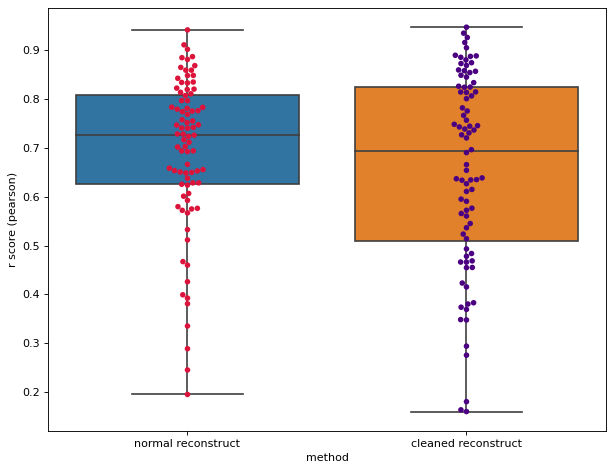

In [84]:
figure(figsize=(9, 7), dpi=80)

sns.boxplot(x="method", y="r score (pearson)", data=pearson_corre_plt, whis=np.inf)
sns.swarmplot(x="method", y="r score (pearson)", data=pearson_corre_plt,
              palette=["crimson","indigo"])
plt.show()

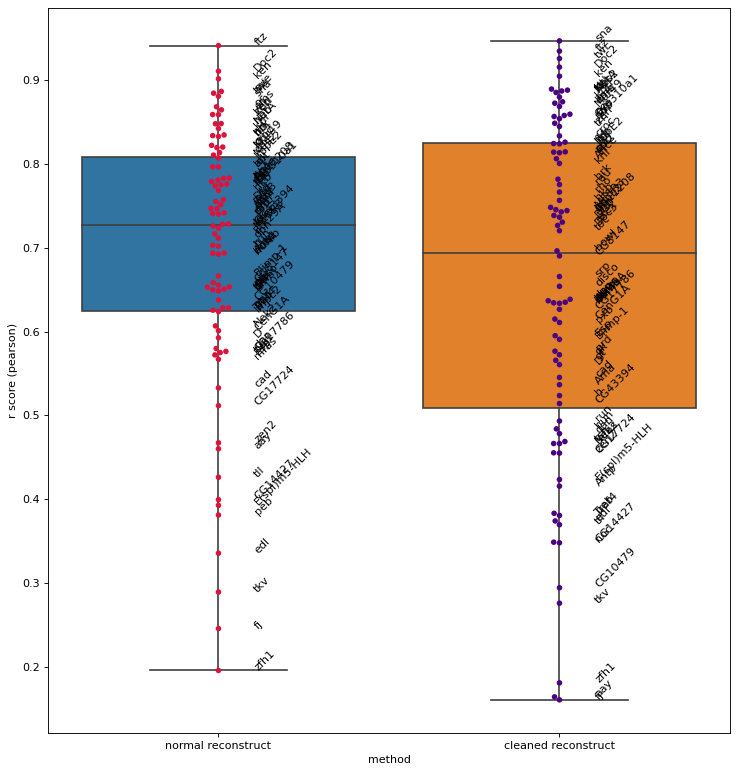

In [96]:
figure(figsize=(11, 12), dpi=80)

sns.boxplot(x="method", y="r score (pearson)", data=pearson_corre_plt, whis=np.inf)
sns.swarmplot(x="method", y="r score (pearson)", data=pearson_corre_plt,
              palette=["crimson","indigo"])

for x,y, label in zip([0]*len(pearson_corre_plt), corre_reconstruction["r score (pearson)"], corre_reconstruction["gene"]):
    plt.text(x = x + 0.1, y = y,
             s = label,
             rotation= 45)

for x,y, label in zip([1]*len(pearson_corre_plt), corre_cleaned["r score (pearson)"], corre_cleaned["gene"]):
    plt.text(x = x + 0.1, y = y,
             s = label,
            rotation= 45)
plt.show()

In [85]:
help(plt.text)

Help on function text in module matplotlib.pyplot:

text(x, y, s, fontdict=None, **kwargs)
    Add text to the Axes.
    
    Add the text *s* to the Axes at location *x*, *y* in data coordinates.
    
    Parameters
    ----------
    x, y : float
        The position to place the text. By default, this is in data
        coordinates. The coordinate system can be changed using the
        *transform* parameter.
    
    s : str
        The text.
    
    fontdict : dict, default: None
        A dictionary to override the default text properties. If fontdict
        is None, the defaults are determined by `.rcParams`.
    
    Returns
    -------
    `.Text`
        The created `.Text` instance.
    
    Other Parameters
    ----------------
    **kwargs : `~matplotlib.text.Text` properties.
        Other miscellaneous text parameters.
    
        Properties:
        agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
     

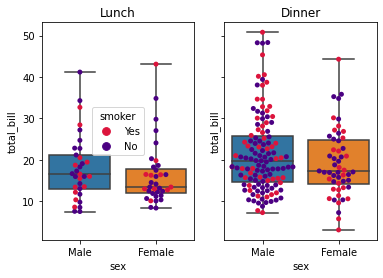

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tips = sns.load_dataset("tips")

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

for ax, (n,grp) in zip(axes, tips.groupby("time")):
    sns.boxplot(x="sex", y="total_bill", data=grp, whis=np.inf, ax=ax)
    sns.swarmplot(x="sex", y="total_bill", hue="smoker", data=grp,
                  palette=["crimson","indigo"], ax=ax)
    ax.set_title(n)
axes[-1].get_legend().remove()
plt.show()

In [103]:
for x in range(10):
    print(x)
    if x > 3:
        break
else:
    print("a")

0
1
2
3
4
